Generate synthetic sinograms for DL training
======================

Using the ASTRA toolbox / TIGRE:

+ Generate virtual objects

+ Forward project the virtual objects
    + Output = perfect sinograms

+ Using the same virtual objects, add random constant and rotation dependent noise, similar magnitude to our detectors
    + Output = corresponding realistic sinograms

+ Learn how to map realistic sinograms to perfect ones.

In [8]:
import astra
import numpy as np
import matplotlib.pyplot as plt # type: ignore
from scipy import ndimage
from typing import List, Union

plt.rcParams["image.cmap"] = "gray"

def plot_it(_objs: List,
            _indices: Union[List[int], np.ndarray],
            _box_aspect: bool = False) -> None:

    fig, ax = plt.subplots(nrows=len(_objs), ncols=len(_indices), dpi=300)
    for row_idx, A in enumerate(_objs):
        vmin = np.percentile(A, 0.5)
        vmax = np.percentile(A, 99.5)
        for col_idx in range(len(_indices)):
            if len(_objs) == 1:
                ax[col_idx].imshow(A[_indices[col_idx]], vmin=vmin, vmax=vmax)
                ax[col_idx].axis("off")
            else:
                ax[row_idx, col_idx].imshow(A[_indices[col_idx]], vmin=vmin, vmax=vmax)
                ax[row_idx, col_idx].axis("off")
            if _box_aspect:
                ax[row_idx, col_idx].set_box_aspect(1)
    fig.tight_layout()
    plt.show()

def create_and_do_reconstruction(
    proj_id, recon_id, recon_algo: str = "FDK_CUDA", iterations: int = 1
):
    assert isinstance(recon_algo, str)
    assert (
        recon_algo == "FDK_CUDA"
        or recon_algo == "CGLS3D_CUDA"
        or recon_algo == "SIRT3D_CUDA"
    ), "Only FDK_CUDA, SIRT3D_CUDA and CGLS3D_CUDA are 'supported'"
    assert isinstance(iterations, int)
    assert iterations >= 1

    print("Starting reconstruction")
    cfg = astra.astra_dict(recon_algo)
    cfg["ProjectionDataId"] = proj_id
    cfg["ReconstructionDataId"] = recon_id
    algo_id = astra.algorithm.create(cfg)
    astra.algorithm.run(algo_id, iterations)
    recon = astra.data3d.get(recon_id)

    return recon, algo_id

def astra_cleanup(algo_id, recon_id, proj_id):
    astra.algorithm.delete(algo_id)
    astra.data3d.delete(recon_id)
    astra.data3d.delete(proj_id)

In [9]:
Y = 256
X = 255
Z = 500 # Z
vol_geom = astra.create_vol_geom(Y, X, Z)
angles = np.linspace(0, 2.0 * np.pi, Z)

print("x, y, z = {}, {}, {}".format(X, Y, Z))
# print(vol_geom)

# Create a hollow 3D rectangular phantom
virtual_object = np.zeros(shape=[Z, Y, X], dtype=np.float32)
S = 50
A1 = int(virtual_object.shape[0]//2 - S*0.9)
A2 = int(virtual_object.shape[0]//2 + S*0.9)
B1 = int(virtual_object.shape[1]//2 - S*1.5)
B2 = int(virtual_object.shape[1]//2 + S*1.5)
C1 = int(virtual_object.shape[2]//2 - S*0.8)
C2 = int(virtual_object.shape[2]//2 + S*0.8)
M = 10
outer_value = 1
inner_value = 0
virtual_object[A1:A2, B1:B2, C1:C2] = 1
virtual_object[A1+M:A2-M, B1+M:B2-M, C1+M:C2-M] = 0

# Rotate in 3 axes
virtual_object = ndimage.rotate(virtual_object, 45, axes=(1, 0), reshape=False)
virtual_object = ndimage.rotate(virtual_object, 30, axes=(2, 1), reshape=False)
virtual_object = ndimage.rotate(virtual_object, 15, axes=(0, 2), reshape=False)

x, y, z = 255, 256, 500


virtual_object is now our precisely known input, no noise of any kind.

What does it look like?

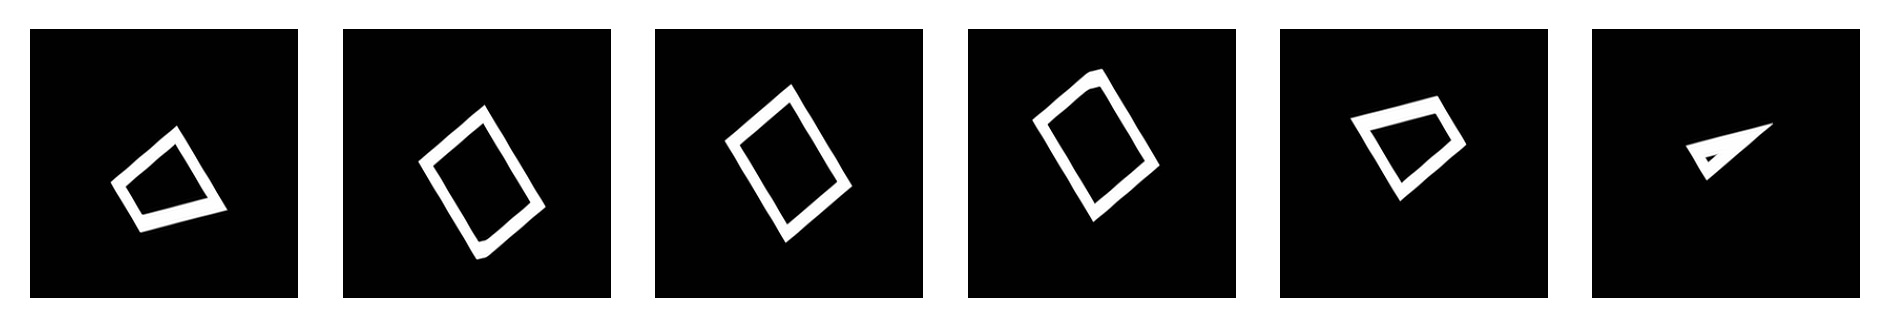

In [10]:
plot_it([virtual_object], np.arange(200,350,25))

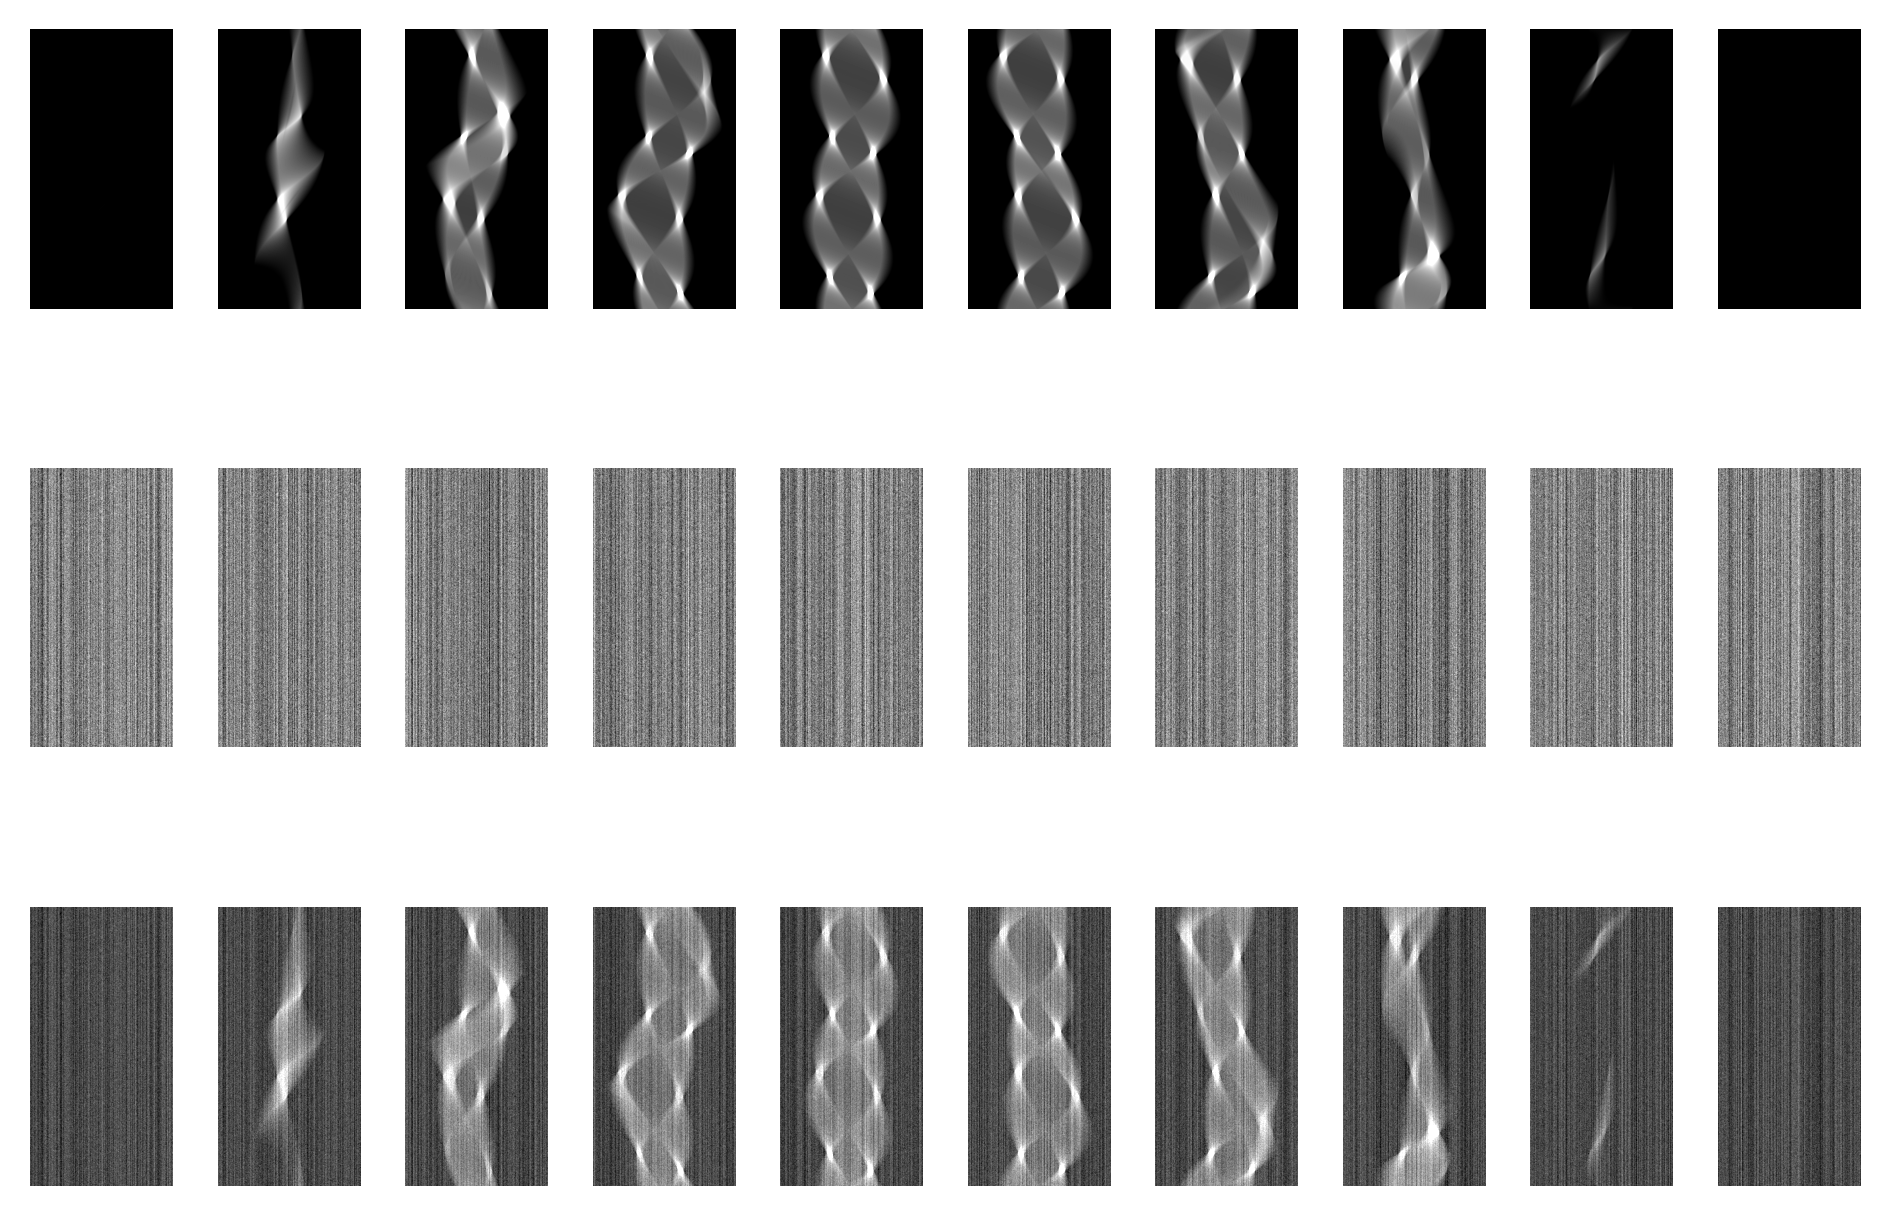

Starting reconstruction


In [11]:
pixel_size_mm = 1
src_to_cor: float = float(
    200 / pixel_size_mm
)  # [px]  distance between the source and the center of rotation
det_to_cor: float = float(
    100 / pixel_size_mm
)  # src2obj * (magn - 1) # 1 [px] distance between the center of rotation and the detector array
magn = (det_to_cor / src_to_cor) + 1.0


# 'cone', detector_spacing_x, detector_spacing_y, det_row_count, det_col_count, angles, source_origin, origin_det
proj_geom = astra.create_proj_geom(
    "cone", magn, magn, Y, X, angles, src_to_cor, det_to_cor
)

# Create projection data from this
proj_id, proj_data = astra.create_sino3d_gpu(virtual_object, proj_geom, vol_geom)


# Add ring artefacts (vertical and horizontal stripes)
noise = np.ones_like(proj_data)
mean = outer_value
std_deviation = 10*mean
# Vertical stripes
for i0 in range(proj_data.shape[0]):
    for i2 in range(proj_data.shape[2]):
        noise[i0, :, i2] += np.random.normal(mean, std_deviation)

noise += np.random.normal(mean, std_deviation, noise.shape)
proj_data_with_noise = proj_data + noise

def plot_sinogram_list(_a: np.ndarray, _indices: List[int]):
    vmin = float(np.percentile(_a, 0.5))
    vmax = float(np.percentile(_a, 99.5))
    fig = plt.figure(figsize=(9,9))
    for i, ii in enumerate(_indices):
        fig.add_subplot(1,len(_indices),i+1)
        plt.imshow(_a[ii], vmin=vmin, vmax=vmax)
        plt.axis('off')
    plt.show()

plot_it([proj_data, noise, proj_data_with_noise], np.arange(20,250,25))

iterations = 50  # Does not affect FDK_CUDA
recon_id = astra.data3d.create("-vol", vol_geom)
proj_id = astra.data3d.create("-sino", proj_geom, proj_data_with_noise)
recon, algo_id = create_and_do_reconstruction(
    proj_id, recon_id, "FDK_CUDA", iterations
)  # 'FDK_CUDA' 'SIRT3D_CUDA' 'CGLS3D_CUDA'

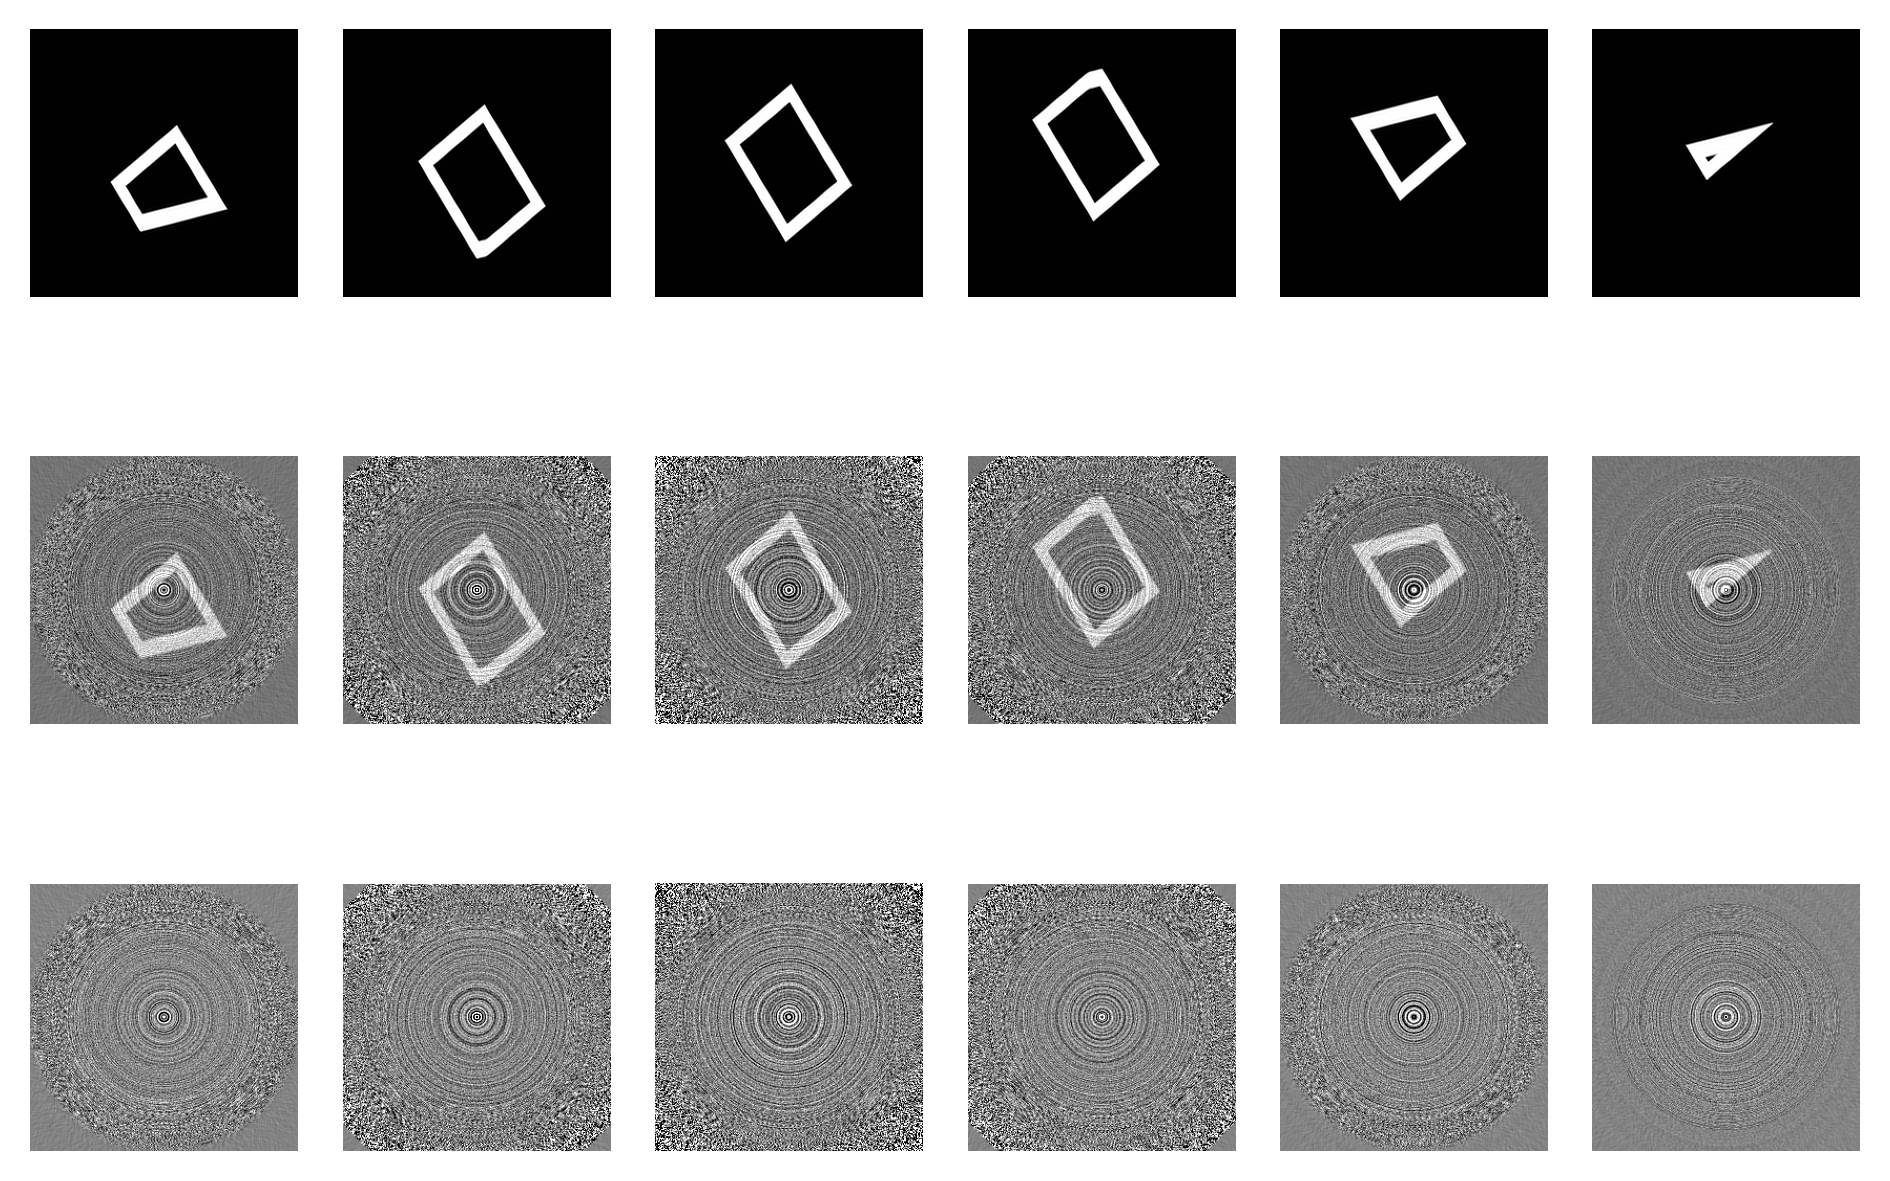

In [12]:
plot_it([virtual_object, recon, virtual_object - recon], np.arange(200,350,25), _box_aspect=True)